# NUCAPS THREDDS Tutorial


### What is THREDDS?

The THREDDS Data Server (TDS) is a web server that provides remote access for scientific datasets. The TDS is developed and supported by Unidata, a division of the University Corporation for Atmospheric Research (UCAR), and is sponsored by the National Science Foundation. THREDDS servers make using scientific data easy. All the files are hosted on the server so there is no need to download files to your local machine. 

### What is NUCAPS? 

The NOAA Unique Combined Atmospheric Processing System (NUCAPS) operationally produces atmospheric sounding products from the Suomi National-Polar-orbiting Partnership (Suomi NPP), NOAA-20, and MetOp series polar orbiting satellites. From each satellite, NUCAPS provides global, twice-daily scans and is available in near real-time. NUCAPS provides vertical profiles of temperature, humidity, and trace gases such as ozone, methane, and carbon monoxide. Gridded NUCAPS was developed to view NUCAPS data horizontally as well as vertically. 

In [11]:
# Packages to load for this tutorial
import numpy as np                         # To perform array operations
import cartopy.crs as ccrs                 # To create map projections for plots
import cartopy.feature as cfeature         # To add maps to plots
import matplotlib.pyplot as plt            # Main plotting library
import xarray as xr                        # For working with netCDF files and large arrays
import netCDF4
from xml.dom import minidom                # For opening xml files
from urllib.request import urlopen, urlretrieve # For opening URL
import fnmatch                             # For indexing python lists
from datetime import datetime, timedelta   # To work with dates

plt.rcParams.update({'font.size': 23})     # Sets fontsize in document to 21pts

In [2]:
server_url='https://renucaps.ssec.wisc.edu/'
catalog_url='thredds/catalog/conusAll/catalog.xml'
url = (server_url + catalog_url)

In [3]:
 # This function returns a sting of all files currently on the server 
def get_elements(url, tag_name, attribute_name):
  """Get elements from an XML file"""
  # usock = urllib2.urlopen(url)
  usock = urlopen(url)
  xmldoc = minidom.parse(usock)
  usock.close()
  tags = xmldoc.getElementsByTagName(tag_name)
  attributes=[]
  for tag in tags:
    attribute = tag.getAttribute(attribute_name)
    attributes.append(attribute)
  return attributes

files = get_elements(url,'dataset','urlPath')
file = (files[-1])                  #This line calls the name of the the most recent file currently hosted on the server
print(file)

conusAll/20220722_1004_gridded_nucaps_noaa20_conus.nc


Notice the format of the file. The first string of numbers is the date of retreval in yyyymmdd. The second string indicates the time of retreval in UTC. If the file reads _"conusAll/20220704_1730_gridded_nucaps_noaa20_conus.nc"_  then the data was retreved July 4, 2022 at 1730 UTC from the NOAA-20 satellite over the continintal United States. 

The THREDDS Data Server supports a variety of web services. In the previous code block we used the Catalog Services to get an .xml document with the names of all the gridded NUCAPS files currently hosted on the server. In in order to open the files, we will use the OPeNDAP DAP2 data access service. We can access this service by adding the Base URL '/thredds/dodsC/'. The THREDDS service offers other support and Data Access Services. You can read more about the different services [here](https://www.unidata.ucar.edu/software/tds/current/reference/Services.html). 

In [4]:
OPeNDAP = 'thredds/dodsC/'
file = (files[-1])
print(server_url+OPeNDAP+file)                   #Prints the full URL we will use for OPeNDAP2 access

https://renucaps.ssec.wisc.edu/thredds/dodsC/conusAll/20220722_1004_gridded_nucaps_noaa20_conus.nc


We can now open the most recent file on the THREDDS server. The xarray package is a flexible and easy to use tool to process multidimentional datasets like Gridded NUCAPS. From the xarray format, the data can easily be converted to numpy arrays, pandas, or plotted with the Matplotlib package.

In [5]:
nucaps = xr.open_dataset(server_url+OPeNDAP+file, chunks={'time': '100MB'}, decode_times=False)

File_DateTime = datetime.utcfromtimestamp(nucaps.time.values[0]).strftime('%Y-%m-%d %H:%M') #Converts epoch time to datetime

Below is an example of plotting the xarray dataset with Matplotlib. For this tutorial we will be plotting the Gridded NUCAPS air temperature at 500mb for the most recent file on the server.

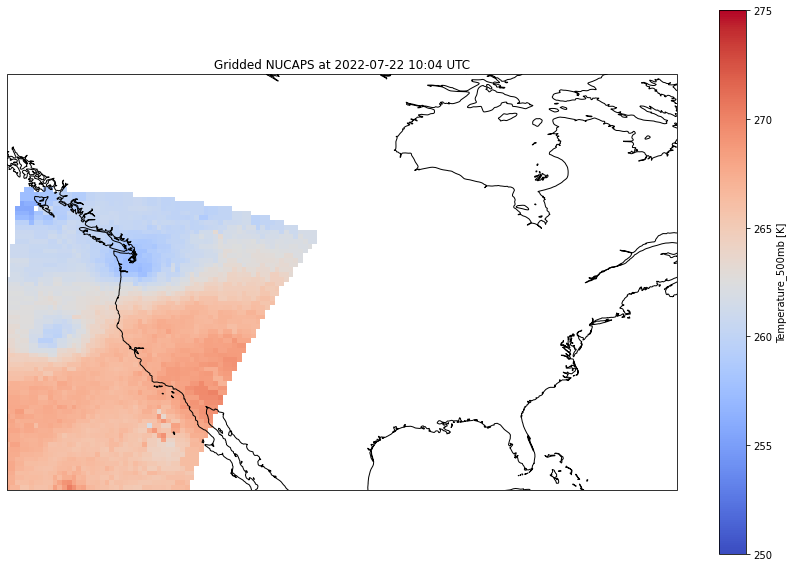

In [7]:
%matplotlib inline
plt.figure(figsize=(15, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
im = nucaps.Temperature_500mb.plot(
    ax=ax, transform=ccrs.PlateCarree(), x="Longitude", y="Latitude",
    cmap=plt.cm.coolwarm,add_colorbar=True, vmin=250, vmax=275)
plt.title("Gridded NUCAPS at " + File_DateTime + " UTC")
ax.set_extent([-65, -136, 63, 23,]) #approximate map extent of CONUS
ax.coastlines()
plt.show()

In [8]:
yesterday = '*' + (datetime.strftime(datetime.now() - timedelta(1), '%Y%m%d')) + '*' #produces string of yesterdays date
yesterday_files = fnmatch.filter(files, yesterday) #filters the entire list of files for just one's tagged yesterday


Below is code for a simple animation for seeing all of the retrevals from the previous day. 

In [10]:
%matplotlib

plt.figure(figsize=(15, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-65, -136, 63, 23,])

for file in yesterday_files:
    ax.cla()
    nucaps = xr.open_dataset(server_url+OPeNDAP+file, decode_times=False)
    File_DateTime = datetime.utcfromtimestamp(nucaps.time.values[0]).strftime('%Y-%m-%d %H:%M')
    im = nucaps.Temperature_500mb.plot(
        ax=ax, transform=ccrs.PlateCarree(), x="Longitude", y="Latitude",
        cmap=plt.cm.coolwarm,add_colorbar=False, vmin=250, vmax=275)
    mappable =  im.axes.collections[0]
    cbar1 = plt.colorbar(mappable,label="Temperature K")
    plt.title("Gridded NUCAPS at " + File_DateTime + " UTC")
    ax.set_extent([-65, -136, 63, 23,])
    ax.coastlines()
    plt.show()
    plt.pause(0.5)
    cbar1.remove() 
bar1 = plt.colorbar(mappable,label="Temperature K")

Using matplotlib backend: Qt5Agg
